In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

! mkdir data

! unzip /content/predict-energy-behavior-of-prosumers.zip -d data

Saving kaggle.json to kaggle.json
 99% 231M/233M [00:11<00:00, 23.6MB/s]
100% 233M/233M [00:11<00:00, 21.3MB/s]
Archive:  /content/predict-energy-behavior-of-prosumers.zip
  inflating: data/client.csv         
  inflating: data/county_id_to_name_map.json  
  inflating: data/electricity_prices.csv  
  inflating: data/enefit/__init__.py  
  inflating: data/enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: data/example_test_files/client.csv  
  inflating: data/example_test_files/electricity_prices.csv  
  inflating: data/example_test_files/forecast_weather.csv  
  inflating: data/example_test_files/gas_prices.csv  
  inflating: data/example_test_files/historical_weather.csv  
  inflating: data/example_test_files/revealed_targets.csv  
  inflating: data/example_test_files/sample_submission.csv  
  inflating: data/example_test_files/test.csv  
  inflating: data/forecast_weather.csv  
  inflating: data/gas_prices.csv     
  inflating: data/historical_weather.csv  
  inflating

In [ ]:
!pip install git+https://github.com/Nixtla/neuralforecast@main # Need to install from git, because latest release does not have callbacks which we want to use in optimization

  Cloning https://github.com/Nixtla/neuralforecast (to revision main) to /tmp/pip-req-build-dvnu_vge
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast /tmp/pip-req-build-dvnu_vge
  Resolved https://github.com/Nixtla/neuralforecast to commit dc030bb3a35008144cbd682dcd3f10e1cd4f1057
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.2 MB/s eta 0

In [ ]:
!pip install --q -U polars numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 49.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install -U pytorch-lightning==2.0.0 optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.3
    Uninstalling pytorch-lightning-2.1.3:
      Successfully uninstalled pytorch-lightning-2.1.3


In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import holidays
import datetime
import warnings
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast

# Data preparation

Follows: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [ ]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [ ]:
def clean_interpolate_timeseries(df_data):

    # don't want this segment, most of the data is missing
    df_data = df_data.loc[
        ~(df_data[["county", "is_business", "product_type"]] == (12, 1, 3)).all(axis=1)
    ]

    chunks = []
    for (county, is_business, product_type), grp in df_data.groupby(
            ["county", "is_business", "product_type"]
    ):
        # interpolate missing values
        interpolated = (
            grp.sort_values(by="datetime")
            .set_index("datetime")
            .interpolate(method="time")
            .reset_index()
        )

        has_gaps = len(interpolated["datetime"].diff().value_counts()) != 1
        if has_gaps:
            # it is assumed that there will be no gaps between observations
            warnings.warn(
                f"{(is_business,product_type,county)=} has gaps in data (there are larger gaps than 1h in datetime column); skipping this series."
            )
            continue
        chunks.append(interpolated)
    df_train_interpolated = pd.concat(chunks).reset_index()

    return df_train_interpolated

In [ ]:
class FeaturesGenerator:
    def __init__(self):
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features


    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "hour", "dayofyear"
        )
        return df_features

    def generate_features(self, df_features):

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        return df_features

In [ ]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [ ]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"
root = "data"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [ ]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [ ]:
feat_gen = FeaturesGenerator()

In [ ]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = feat_gen.generate_features(df_train)
df_train = clean_interpolate_timeseries(to_pandas(df_train))

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [ ]:
# Remove old data
df_train = df_train[df_train["datetime"] >= pd.to_datetime("2022-11-03 00:00:00")]
df_train = df_train[df_train["datetime"] <= pd.to_datetime("2023-05-24 23:00:00")]

In [ ]:
df_train.shape

(302064, 34)

In [ ]:
df_train.columns

Index(['index', 'datetime', 'county', 'is_business', 'product_type',
       'production', 'consumption', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'eic_count', 'installed_capacity',
       'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'day', 'weekday', 'month', 'year',
       'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)',
       'is_country_holiday'],
      dtype='object')

In [ ]:
df_train.isna().sum()

index                                0
datetime                             0
county                               0
is_business                          0
product_type                         0
production                           0
consumption                          0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
eic_count                            0
installed_capacity                   0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
day                                  0
weekday                  

In [ ]:
static_df = df_train[["segment", "county", "is_business", "product_type"]]
static_df = static_df.drop_duplicates().rename(columns={'segment':'unique_id'})

# 2. Forecasting PRODUCTION

Follows: https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [ ]:
import optuna
from neuralforecast.losses.pytorch import MAE

In [ ]:
static = ["county", "is_business", "product_type"]
past_covariates = ["consumption","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards",
                    "sin(dayofyear)","cos(dayofyear)", "sin(hour)", "cos(hour)", "is_country_holiday"]

In [ ]:
from neuralforecast.losses.numpy import mae
import optuna

In [ ]:
from neuralforecast.models import MLP

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

# Because optuna does not support the latest lightning version...
# https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [ ]:
# TRAIN-TEST split

start_date = pd.to_datetime("2022-11-03 00:00:00")
end_date = pd.to_datetime("2023-05-24 23:00:00")
datetime_range = pd.date_range(start=start_date, end=end_date, freq='H')

test_cutoff = pd.to_datetime("2023-05-15 09:00:00") # This will give leave about 0.95 to train and 0.05 to test. Done to match neuralforecast internal split

train_datetime_range = datetime_range[datetime_range < test_cutoff]
test_datetime_range = datetime_range[datetime_range >= test_cutoff]

train = df_train[df_train['datetime'].isin(train_datetime_range)]
test = df_train[df_train['datetime'].isin(test_datetime_range)]

In [ ]:
len(train) / len(df_train)

0.9525862068965517

In [ ]:
len(test) / len(df_train)

0.04741379310344827

In [ ]:
import torch
import gc

In [ ]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)
    hidden_size = trial.suggest_categorical("hidden_size", [256, 512, 1024])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [128, 256, 512, 1024])
    random_seed = trial.suggest_int("random_seed", 1, 20)
    num_layers = trial.suggest_int("num_layers", 1, 3)

    models =  [MLP(h=output_size,
                   input_size=input_size,
                   stat_exog_list=static,
                   hist_exog_list=past_covariates,
                   futr_exog_list=future_covariates,
                   hidden_size=hidden_size,
                   num_layers=num_layers,
                   loss=MAE(),
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=random_seed)]

    n_time = len(train['datetime'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None,
                                  static_df=static_df.rename(columns={'segment':'unique_id'}))

    loss = mae(Y_hat_df['y'], Y_hat_df['MLP'])

    return loss if loss != np.nan else float("inf")

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-23 15:16:33,332] A new study created in memory with name: no-name-a0bb063c-3c85-4df9-b04a-351ed0a5e301
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:17:27,300] Trial 0 finished with value: 83.11963653564453 and parameters: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 2


Current value: 83.11963653564453, Current params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:17:57,261] Trial 1 finished with value: 444.5472106933594 and parameters: {'input_size': 112, 'hidden_size': 256, 'learning_rate': 0.08937956454466095, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 2, 'num_layers': 2}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 444.5472106933594, Current params: {'input_size': 112, 'hidden_size': 256, 'learning_rate': 0.08937956454466095, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 2, 'num_layers': 2}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:18:41,761] Trial 2 finished with value: 84.74479675292969 and parameters: {'input_size': 111, 'hidden_size': 1024, 'learning_rate': 2.54478846862237e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 1, 'num_layers': 3}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 19


Current value: 84.74479675292969, Current params: {'input_size': 111, 'hidden_size': 1024, 'learning_rate': 2.54478846862237e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 1, 'num_layers': 3}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:20:04,543] Trial 3 finished with value: 533.126953125 and parameters: {'input_size': 105, 'hidden_size': 256, 'learning_rate': 1.1948215472563032e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 19, 'num_layers': 3}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 15


Current value: 533.126953125, Current params: {'input_size': 105, 'hidden_size': 256, 'learning_rate': 1.1948215472563032e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 19, 'num_layers': 3}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:20:55,376] Trial 4 finished with value: 209.1473388671875 and parameters: {'input_size': 245, 'hidden_size': 512, 'learning_rate': 1.1723525682904944e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 15, 'num_layers': 1}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 8


Current value: 209.1473388671875, Current params: {'input_size': 245, 'hidden_size': 512, 'learning_rate': 1.1723525682904944e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 15, 'num_layers': 1}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:21:21,093] Trial 5 finished with value: 89.95147705078125 and parameters: {'input_size': 158, 'hidden_size': 256, 'learning_rate': 0.0004955873539866678, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 8, 'num_layers': 1}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 7


Current value: 89.95147705078125, Current params: {'input_size': 158, 'hidden_size': 256, 'learning_rate': 0.0004955873539866678, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 8, 'num_layers': 1}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:21:51,242] Trial 6 finished with value: 403.4184265136719 and parameters: {'input_size': 165, 'hidden_size': 1024, 'learning_rate': 0.06260688512887053, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 7, 'num_layers': 2}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 18


Current value: 403.4184265136719, Current params: {'input_size': 165, 'hidden_size': 1024, 'learning_rate': 0.06260688512887053, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 7, 'num_layers': 2}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:22:29,660] Trial 7 finished with value: 795.040771484375 and parameters: {'input_size': 317, 'hidden_size': 512, 'learning_rate': 4.833090684211071e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 1024, 'random_seed': 18, 'num_layers': 3}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 12


Current value: 795.040771484375, Current params: {'input_size': 317, 'hidden_size': 512, 'learning_rate': 4.833090684211071e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 1024, 'random_seed': 18, 'num_layers': 3}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:23:11,396] Trial 8 finished with value: 403.42169189453125 and parameters: {'input_size': 321, 'hidden_size': 256, 'learning_rate': 0.00787903418541406, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 256, 'random_seed': 12, 'num_layers': 2}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 2


Current value: 403.42169189453125, Current params: {'input_size': 321, 'hidden_size': 256, 'learning_rate': 0.00787903418541406, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 256, 'random_seed': 12, 'num_layers': 2}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:23:28,640] Trial 9 finished with value: 156.77645874023438 and parameters: {'input_size': 154, 'hidden_size': 1024, 'learning_rate': 0.0002035891053854771, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 2, 'num_layers': 1}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Current value: 156.77645874023438, Current params: {'input_size': 154, 'hidden_size': 1024, 'learning_rate': 0.0002035891053854771, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 2, 'num_layers': 1}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:23:42,197] Trial 10 finished with value: 193.37278747558594 and parameters: {'input_size': 261, 'hidden_size': 256, 'learning_rate': 0.0050794832423987565, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 256, 'random_seed': 6, 'num_layers': 3}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 193.37278747558594, Current params: {'input_size': 261, 'hidden_size': 256, 'learning_rate': 0.0050794832423987565, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 256, 'random_seed': 6, 'num_layers': 3}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:24:00,384] Trial 11 finished with value: 100.7821273803711 and parameters: {'input_size': 73, 'hidden_size': 1024, 'learning_rate': 9.356968758134281e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'random_seed': 1, 'num_layers': 3}. Best is trial 0 with value: 83.11963653564453.
INFO:lightning_fabric.utilities.seed:Global seed set to 5


Current value: 100.7821273803711, Current params: {'input_size': 73, 'hidden_size': 1024, 'learning_rate': 9.356968758134281e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'random_seed': 1, 'num_layers': 3}
Best value: 83.11963653564453, Best params: {'input_size': 306, 'hidden_size': 256, 'learning_rate': 0.0001424557589079827, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 6, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:24:25,521] Trial 12 finished with value: 79.82635498046875 and parameters: {'input_size': 234, 'hidden_size': 1024, 'learning_rate': 4.968918623258983e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}. Best is trial 12 with value: 79.82635498046875.
INFO:lightning_fabric.utilities.seed:Global seed set to 5


Current value: 79.82635498046875, Current params: {'input_size': 234, 'hidden_size': 1024, 'learning_rate': 4.968918623258983e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}
Best value: 79.82635498046875, Best params: {'input_size': 234, 'hidden_size': 1024, 'learning_rate': 4.968918623258983e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:25:03,990] Trial 13 finished with value: 89.05671691894531 and parameters: {'input_size': 262, 'hidden_size': 1024, 'learning_rate': 0.0011421134151086286, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}. Best is trial 12 with value: 79.82635498046875.
INFO:lightning_fabric.utilities.seed:Global seed set to 11


Current value: 89.05671691894531, Current params: {'input_size': 262, 'hidden_size': 1024, 'learning_rate': 0.0011421134151086286, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}
Best value: 79.82635498046875, Best params: {'input_size': 234, 'hidden_size': 1024, 'learning_rate': 4.968918623258983e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:25:17,111] Trial 14 finished with value: 134.3035430908203 and parameters: {'input_size': 232, 'hidden_size': 512, 'learning_rate': 0.00017923410388632704, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 11, 'num_layers': 2}. Best is trial 12 with value: 79.82635498046875.
INFO:lightning_fabric.utilities.seed:Global seed set to 9


Current value: 134.3035430908203, Current params: {'input_size': 232, 'hidden_size': 512, 'learning_rate': 0.00017923410388632704, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 11, 'num_layers': 2}
Best value: 79.82635498046875, Best params: {'input_size': 234, 'hidden_size': 1024, 'learning_rate': 4.968918623258983e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:25:41,070] Trial 15 finished with value: 107.50047302246094 and parameters: {'input_size': 292, 'hidden_size': 256, 'learning_rate': 0.0008261318762488782, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'random_seed': 9, 'num_layers': 3}. Best is trial 12 with value: 79.82635498046875.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 107.50047302246094, Current params: {'input_size': 292, 'hidden_size': 256, 'learning_rate': 0.0008261318762488782, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'random_seed': 9, 'num_layers': 3}
Best value: 79.82635498046875, Best params: {'input_size': 234, 'hidden_size': 1024, 'learning_rate': 4.968918623258983e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 5, 'num_layers': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:26:12,589] Trial 16 finished with value: 74.00049591064453 and parameters: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}. Best is trial 16 with value: 74.00049591064453.


Current value: 74.00049591064453, Current params: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}
Best value: 74.00049591064453, Best params: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}


INFO:lightning_fabric.utilities.seed:Global seed set to 5


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:26:39,149] Trial 17 finished with value: 94.44959259033203 and parameters: {'input_size': 202, 'hidden_size': 1024, 'learning_rate': 3.7118863409110686e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 256, 'random_seed': 5, 'num_layers': 2}. Best is trial 16 with value: 74.00049591064453.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 94.44959259033203, Current params: {'input_size': 202, 'hidden_size': 1024, 'learning_rate': 3.7118863409110686e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 256, 'random_seed': 5, 'num_layers': 2}
Best value: 74.00049591064453, Best params: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:26:52,790] Trial 18 finished with value: 379.0707702636719 and parameters: {'input_size': 202, 'hidden_size': 1024, 'learning_rate': 0.003670554875513101, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 4, 'num_layers': 2}. Best is trial 16 with value: 74.00049591064453.
INFO:lightning_fabric.utilities.seed:Global seed set to 13


Current value: 379.0707702636719, Current params: {'input_size': 202, 'hidden_size': 1024, 'learning_rate': 0.003670554875513101, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 4, 'num_layers': 2}
Best value: 74.00049591064453, Best params: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-23 15:27:15,205] Trial 19 finished with value: 129.5817108154297 and parameters: {'input_size': 218, 'hidden_size': 1024, 'learning_rate': 6.476228257835118e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 13, 'num_layers': 2}. Best is trial 16 with value: 74.00049591064453.


Current value: 129.5817108154297, Current params: {'input_size': 218, 'hidden_size': 1024, 'learning_rate': 6.476228257835118e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 13, 'num_layers': 2}
Best value: 74.00049591064453, Best params: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}
Best value: 74.00049591064453, Best params: {'input_size': 203, 'hidden_size': 1024, 'learning_rate': 5.247200680118131e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 4, 'num_layers': 2}


In [ ]:
study.best_trial.params

{'input_size': 203,
 'hidden_size': 1024,
 'learning_rate': 5.247200680118131e-05,
 'scaler_type': None,
 'batch_size': 32,
 'windows_batch_size': 512,
 'random_seed': 4,
 'num_layers': 2}

In [ ]:
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models =  [MLP(h=2*24,
                input_size=203,
                stat_exog_list=static,
                hist_exog_list=past_covariates,
                futr_exog_list=future_covariates,
                hidden_size=1024,
                loss=MAE(),
                max_steps=1000, # 1000 is the default
                learning_rate=5.247200680118131e-05,
                val_check_steps=100, # 100 is the default
                early_stop_patience_steps=3,
                batch_size=32,
                windows_batch_size=512,
                scaler_type=None,
                random_seed=4)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 4


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
from neuralforecast.losses.numpy import mae
mae_MLP = mae(Y_hat_df['y'], Y_hat_df['MLP'])
mae_MLP

120.65083

In [ ]:
Y_hat_df = Y_hat_df.reset_index()

Internally, neuralforecast does rolling prediction on the test set, using the lates available data in the lookback window.

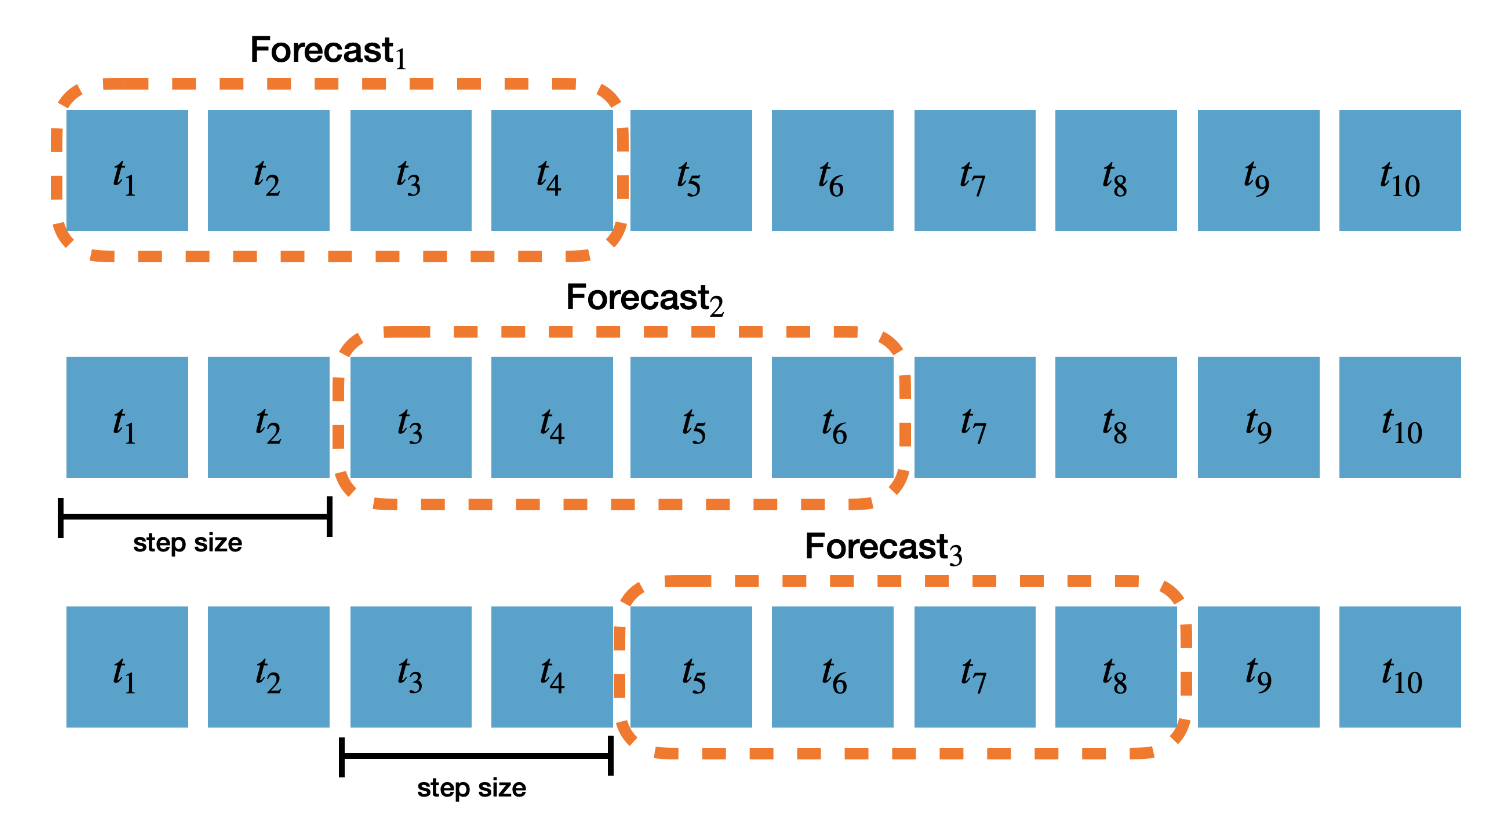

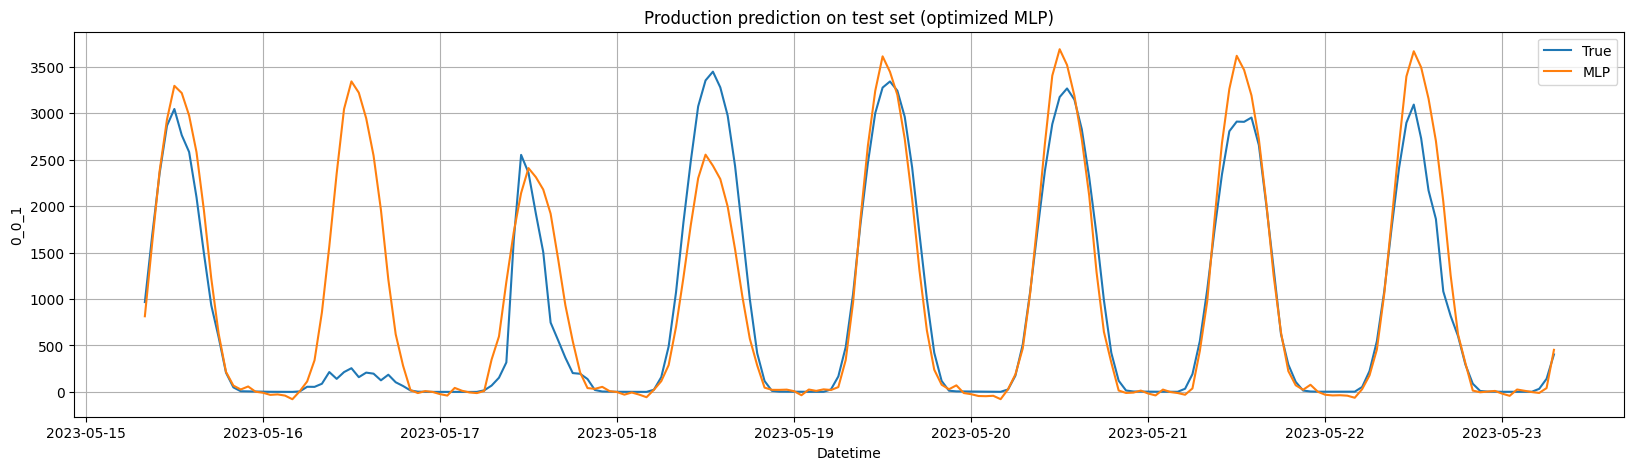

In [ ]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Production prediction on test set (optimized MLP)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['MLP'], label='MLP')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('production_preds_optimized_MLP.png')
plt.show()